In [1]:
# !pip install pandas matplotlib

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

In [3]:
log_file = "workload.log"
rq_stats_file = "range_queries.csv"

# CPU & IO Stats File
cpu_iostat_file = "cpu_iostat.txt"
cpu_top_file = "cpu_top.txt"
io_iostat_file = "io_iostat.txt"

CWD = os.getcwd()

In [4]:
def read_epochs_data(filename, time_stats=False):
    """Read `workload.log` file and return one epoch data"""
    
    with open(filename, 'r') as file:
        epoch_data = []
        grabbing_data = False
        for line in file:
            line = line.strip()
            if line.startswith("====================="):
                if grabbing_data:
                    yield epoch_data
                    epoch_data = []
                    grabbing_data = False
            elif grabbing_data:
                epoch_data.append(line)
            else:
                grabbing_data = True
                epoch_data.append(line)
        if time_stats:
            yield epoch_data

In [5]:
def extract_column_family(lines):
    """Extract Column Family information from one epoch data"""
    
    # Initialize variables to store column family data
    column_family_data = {"Levels": []}
    sst_files = {}
    i = 0

    # Process each line
    while i < len(lines):
        line = lines[i]
        # Check if the line contains column family data
        if line.startswith("Column Family Name"):
            key_val = line.split(',')
            column_family_data["Column Family Name"] = key_val[0].split(':')[1].strip().strip(',')
            column_family_data["Size"] = int(key_val[1].split(':')[1].strip().strip(',').strip(' bytes'))
            column_family_data["Files Count"] = int(key_val[2].split(':')[1].strip().strip(','))
            column_family_data["Entries Count"] = int(key_val[3].split(':')[1].strip().strip(','))
            column_family_data["Invalid Entries Count"] = int(key_val[4].split(':')[1].strip().strip(','))
        if "Level:" in line:
            key_val = line.strip().split(',')
            level = int(key_val[0].split(":")[1].strip().strip(','))
            level_size = int(key_val[1].split(':')[1].strip().strip(',').strip(' bytes'))
            level_files_count = int(key_val[2].split(':')[1].strip().strip(','))

            key_val_sst_files = lines[i+1].split('],')[:-1]
            sst_files = []
            
            for sst_file_string in key_val_sst_files:
                # Extract SST file details
                file_number = int(sst_file_string.split(":")[0].split("[#")[1].strip())
                file_details = sst_file_string.split(":")[1].strip().split()
                file_size = int(file_details[0].strip())
                smallest_key = int(file_details[1].strip(',').strip('('))
                largest_key = int(file_details[2].strip(')'))
                entries_count = int(file_details[3].strip(']'))

                sst_files.append({
                    "FNo": file_number,
                    "FileSize": file_size,
                    "SmallesKey": smallest_key,
                    "LargestKey": largest_key,
                    "EntriesCount": entries_count
                })
            
            if len(sst_files) > 0:
                column_family_data["Levels"].append({
                    "Level": level,
                    "LevelSize": level_size,
                    "LevelFilesCount": level_files_count,
                    "SSTFiles": sst_files
                })
            i += 1

        i += 1

    return column_family_data

In [6]:
def extract_total_write_bytes(one_epoch):
    """
    rocksdb.compact.read.bytes
    rocksdb.compact.write.bytes
    rocksdb.flush.write.bytes
    """
    read_bytes = 0
    write_bytes = 0

    for line in one_epoch:
        if line.startswith("rocksdb.compact.read.bytes"):
            read_bytes += int(line.split(':')[1])
        elif line.startswith('rocksdb.compact.write.bytes') or line.startswith('rocksdb.flush.write.bytes'):
            write_bytes += int(line.split(':')[1])
    
    return read_bytes, write_bytes

In [7]:
def get_execution_times(one_epoch):
    """
    Workload Execution Time: 
    Operations Execution Time: 
    All Inserts Time: 
    All Updates Time: 
    All Range Queries Time: 
    """
    workload_execution_time = 0
    operation_time = 0
    inserts_time = 0
    updates_time = 0
    range_queries_time = 0

    for line in one_epoch:
        if line.startswith("Workload Execution Time:"):
            workload_execution_time = int(line.split(':')[1].strip())
        if line.startswith("Operations Execution Time"):
            operation_time = int(line.split(':')[1].strip())
        if line.startswith("All Inserts Time"):
            inserts_time = int(line.split(':')[1].strip())
        if line.startswith("All Updates Time"):
            updates_time = int(line.split(':')[1].strip())
        if line.startswith("All Range Queries Time"):
            range_queries_time = int(line.split(':')[1].strip())

    return [workload_execution_time, operation_time, inserts_time, updates_time, range_queries_time]

In [8]:
# Find compaction debt, write amplification and entries per file

def compaction_debt(cfd_data):
    # Iterate through levels, summing up entries count for levels except the last one
    compaction_debt = 0

    sorted_levels = sorted(cfd_data['Levels'], key=lambda x: x['Level'])
    
    for level in sorted_levels[:-1]:
        for sst_file in level['SSTFiles']:
            compaction_debt += sst_file['EntriesCount']

    return compaction_debt

def write_amplification_debt(cfd_data, size_ratio):
    entries_list = list()

    sorted_levels = sorted(cfd_data['Levels'], key=lambda x: x['Level'])

    for level in sorted_levels[:-1]:
        for sst_file in level["SSTFiles"]:
            entries_list.append(sst_file['EntriesCount'])
    
    return sum([entries * (len(entries_list) - index + 1) for index, entries in enumerate(entries_list, 1)])

def avg_entries_per_SST_file(cfd_data):
    total_entries = 0
    total_sst_files = 0

    # Iterate through each level
    for level in cfd_data['Levels']:
        # Iterate through SST files in each level
        for sst_file in level['SSTFiles']:
            total_entries += sst_file['EntriesCount']
            # total_sst_files += 1
    
    return total_entries / cfd_data["Files Count"]
    # return total_entries / total_sst_files

In [9]:
def autolabel(rectangle_group):
    for rect in rectangle_group:
        height = rect.get_height()
        ax.annotate(f"{height}",
                xy = (rect.get_x() + rect.get_width() / 2, height),
                ha='center', color = 'grey', rotation=90, xytext=(0,5), textcoords="offset points")

def autolabel_percent(label_on_rect, compute_with_rect):
    for label_on, compute_from in zip(label_on_rect, compute_with_rect):
        label = (compute_from.get_height() - label_on.get_height()) / compute_from.get_height()
        height = label_on.get_height()
        ax.annotate(f"{label:.2f}",
                xy = (label_on.get_x() + label_on.get_width() / 2, height),
                ha='center', color = 'grey', rotation=90, xytext=(0,5), textcoords="offset points")

def convert_ns_to_sec(val):
    return val / (10**9)

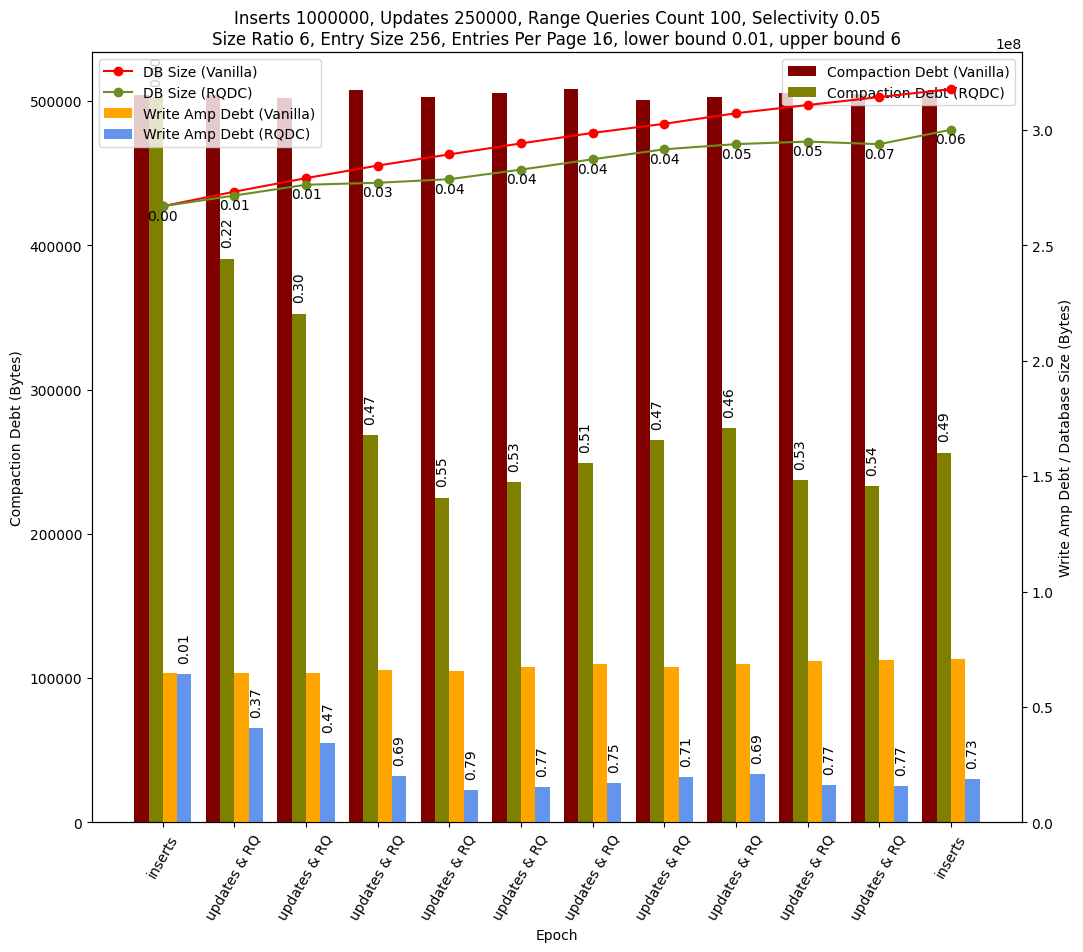

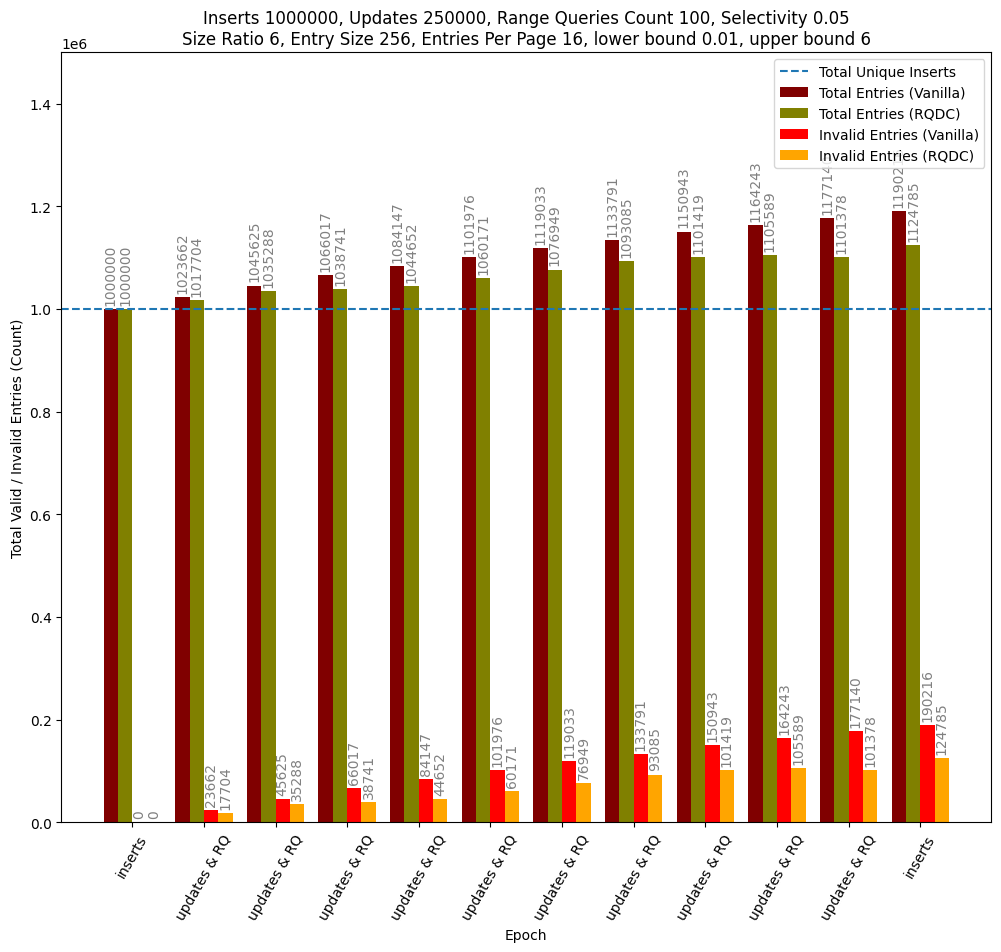

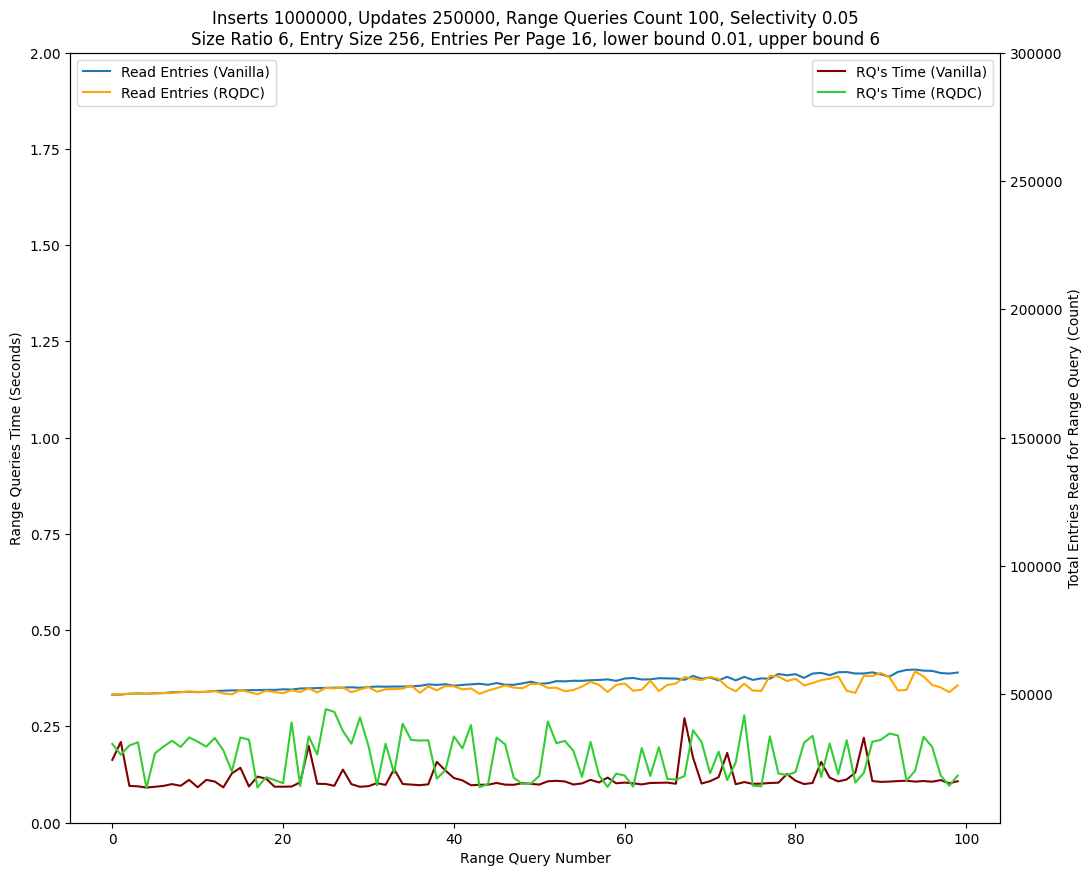

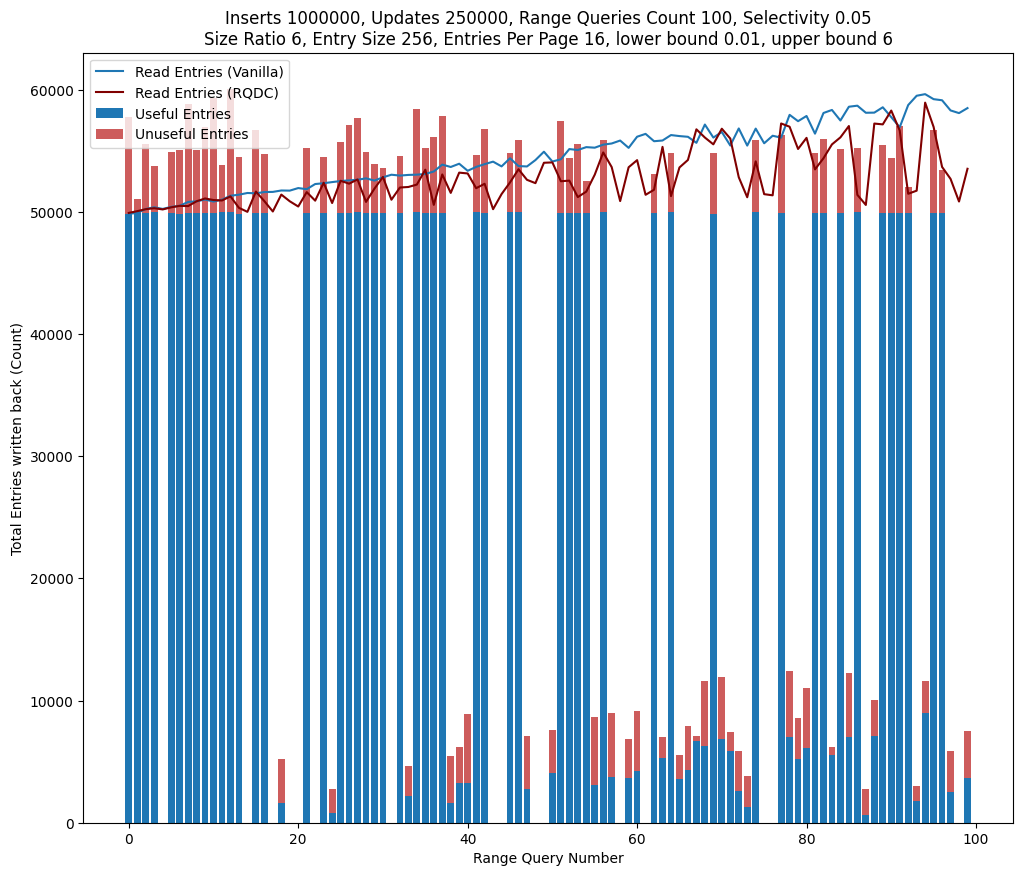

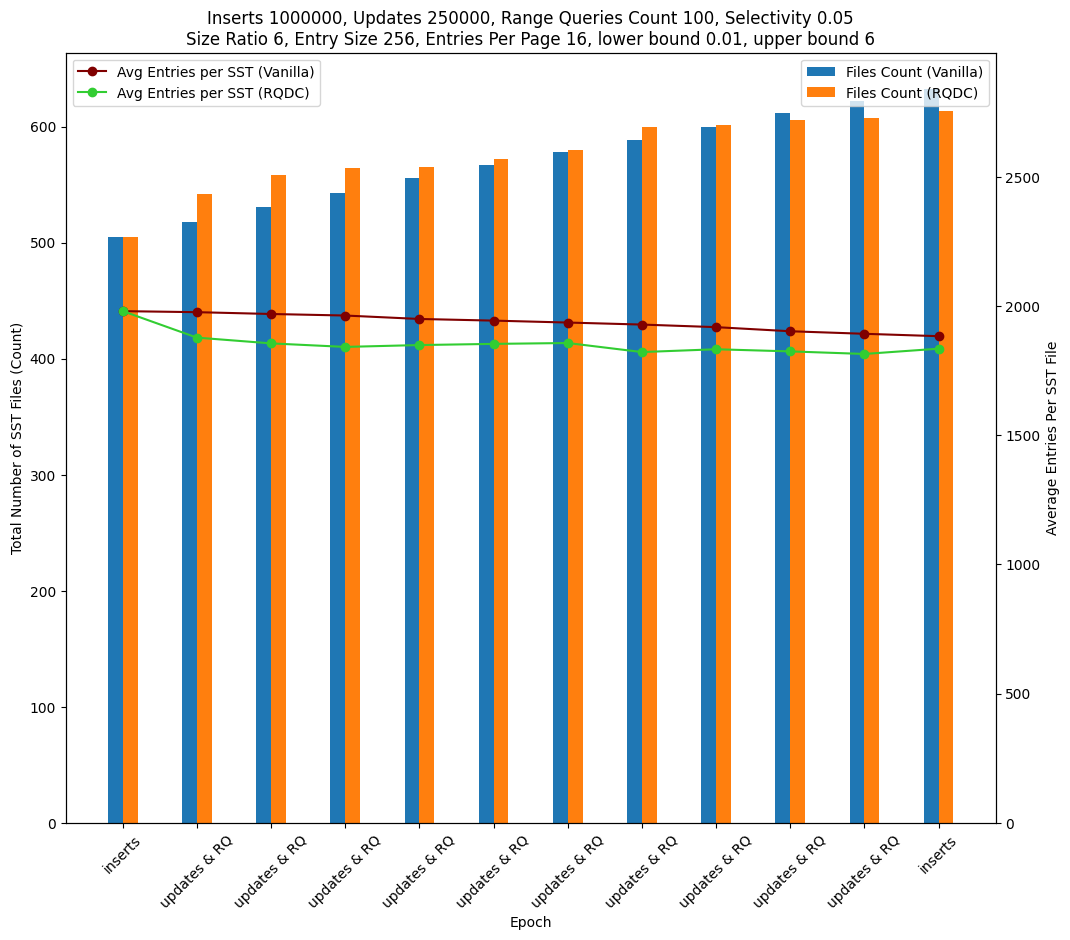

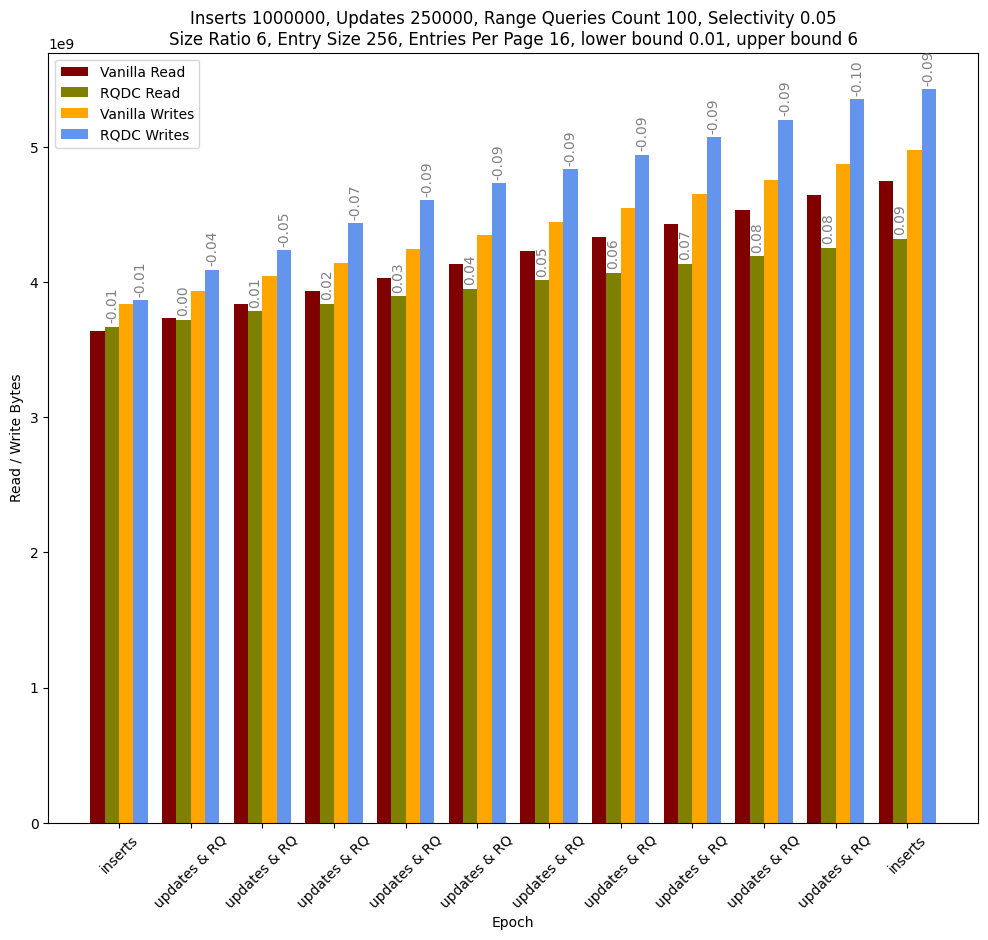

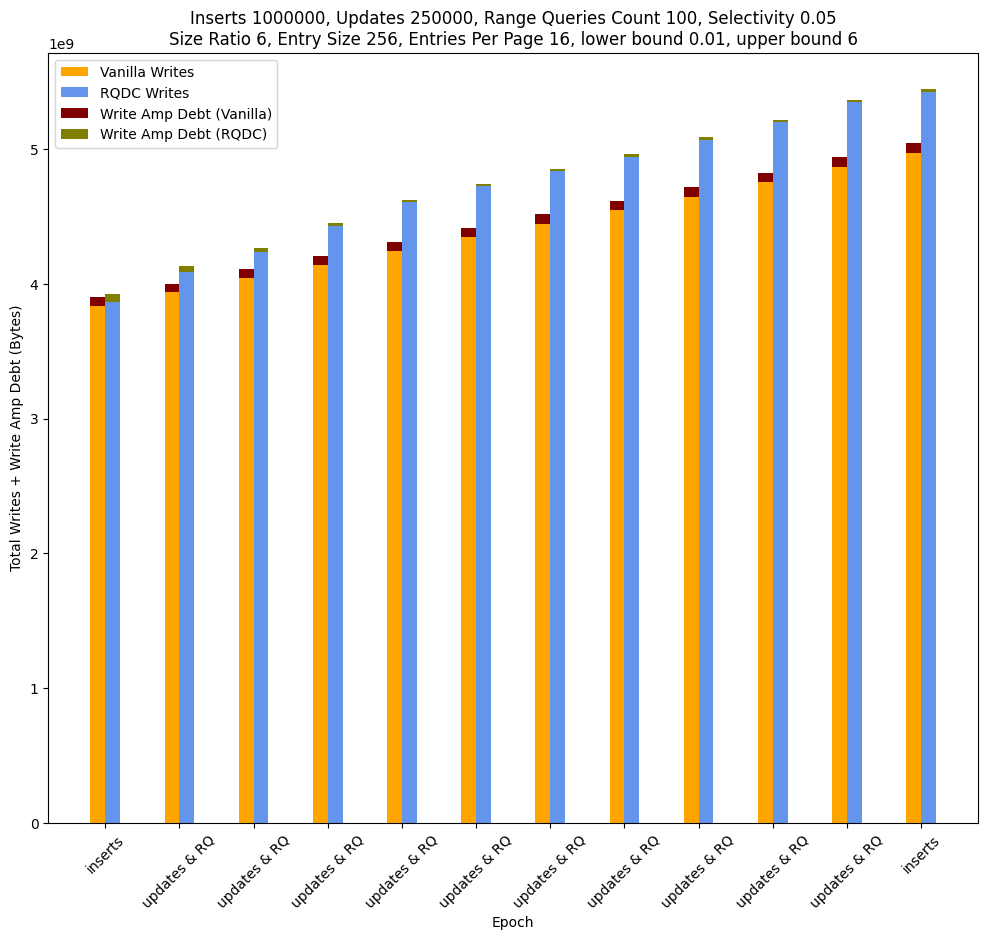

In [10]:
lower_bounds = [0.01] # [0.01, 0.1, 0.25]
upper_bounds = [6]

plot_for = [
    # {
    #     "inserts": 1000000,
    #     "updates": 250000,
    #     "range": 100,
    #     "selectivity": 0.1,
    #     "sizeRatio": 6,
    #     "entrySize": 32,
    #     "entriesPerPage": 128,
    #     "lowerBound": 0.12,
    #     "upperBound": 2,
    # },
]
lower_upper_bounds = list()

for lb in lower_bounds:
    for ub in upper_bounds:
        if lb < ub:
            lower_upper_bounds.append((lb, ub))
            plot_for.append(
                {
                    "inserts": 1000000,
                    "updates": 250000,
                    "range": 100,
                    "selectivity": 0.05,
                    "sizeRatio": 6,
                    "entrySize": 256,
                    "entriesPerPage": 16,
                    "lowerBound": lb,
                    "upperBound": ub,
                }
            )


FIG_SIZE = (12, 10)

for exp in plot_for:
    vanilla_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 0 E {exp['entrySize']} B {exp['entriesPerPage']}"
    )
    rqdc_dir_name = (
        f"I {exp['inserts']} U {exp['updates']} S {exp['range']} Y {exp['selectivity']} "
        f"T {exp['sizeRatio']} rq 1 E {exp['entrySize']} B {exp['entriesPerPage']} "
        f"lb {exp['lowerBound']} ub {exp['upperBound']}"
    )

    if not os.path.exists((os.path.join(CWD, vanilla_dir_name))) or not os.path.exists(
        os.path.join(CWD, rqdc_dir_name)
    ):
        raise FileNotFoundError("Directory Not Found!!!")

    first = True
    vanilla_stats = list()
    rqdc_stats = list()

    vanilla_rq_stats = None
    rqdc_rq_stats = None

    for one_epoch in read_epochs_data(os.path.join(CWD, vanilla_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt(cf_data, exp['sizeRatio'])
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            vanilla_stats.append(
                {
                    "CompactionDebt": one_epoch_cd,
                    "WriteAmpDebt": one_epoch_wa,
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    vanilla_rq_stats = pd.read_csv(os.path.join(CWD, vanilla_dir_name, rq_stats_file))
    vanilla_rq_stats = vanilla_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    vanilla_rq_stats.columns = vanilla_rq_stats.columns.str.strip()

    first = True

    for one_epoch in read_epochs_data(os.path.join(CWD, rqdc_dir_name, log_file)):
        if first:
            first = False
        else:
            cf_data = extract_column_family(one_epoch)
            read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
            one_epoch_cd = compaction_debt(cf_data)
            one_epoch_wa = write_amplification_debt(cf_data, exp['sizeRatio'])
            one_epoch_epf = avg_entries_per_SST_file(cf_data)

            rqdc_stats.append(
                {
                    "CompactionDebt": one_epoch_cd,
                    "WriteAmpDebt": one_epoch_wa,
                    "AvgEntriesPerSST": one_epoch_epf,
                    "FilesCount": cf_data["Files Count"],
                    "DBSize": cf_data["Size"],
                    "TotalEntries": cf_data["Entries Count"],
                    "Invalid Entries": cf_data["Invalid Entries Count"],
                    "TotalReadBytes": read_bytes,
                    "TotalWriteBytes": write_bytes,
                }
            )
    rqdc_rq_stats = pd.read_csv(os.path.join(CWD, rqdc_dir_name, rq_stats_file))
    rqdc_rq_stats = rqdc_rq_stats.applymap(
        lambda x: x.strip(" ") if isinstance(x, str) else x
    )
    rqdc_rq_stats.columns = rqdc_rq_stats.columns.str.strip()

    x_tick_labels = [
        "inserts",
        "updates & RQ",
        "updates & RQ",
        "updates & RQ",
        "updates & RQ",
        "updates & RQ",
        "updates & RQ",
        "updates & RQ",
        "updates & RQ",
        "updates & RQ",
        "updates & RQ",
        "inserts",
    ]

    # ============================================================================= #
    #                    COMPACTION DEBT, WRITE AMP DEBT & DB SIZE                  #
    # ============================================================================= #

    width = 0.2
    num_epochs = 12

    x_compaction_dbt_van = [x - 0.3 for x in range(num_epochs)]
    x_compaction_dbt_rqdc = [x - 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_van = [x + 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_rqdc = [x + 0.3 for x in range(num_epochs)]

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    ax2 = ax.twinx()

    comp_dbt_van = ax.bar(
        x_compaction_dbt_van,
        [stat["CompactionDebt"] for stat in vanilla_stats],
        width,
        label="Compaction Debt (Vanilla)",
        color="maroon",
    )
    comp_dbt_rqdc = ax.bar(
        x_compaction_dbt_rqdc,
        [stat["CompactionDebt"] for stat in rqdc_stats],
        width,
        label="Compaction Debt (RQDC)",
        color="olive",
    )
    write_amp_van = ax2.bar(
        x_write_amp_dbt_van,
        [stat["WriteAmpDebt"] for stat in vanilla_stats],
        width,
        label=("Write Amp Debt (Vanilla)"),
        color="orange",
    )
    write_amp_rqdc = ax2.bar(
        x_write_amp_dbt_rqdc,
        [stat["WriteAmpDebt"] for stat in rqdc_stats],
        width,
        label="Write Amp Debt (RQDC)",
        color="cornflowerblue",
    )
    point1 = ax2.plot(
        range(12),
        [stat["DBSize"] for stat in vanilla_stats],
        label="DB Size (Vanilla)",
        color="red",
        marker="o",
    )
    point2 = ax2.plot(
        range(12),
        [stat["DBSize"] for stat in rqdc_stats],
        label="DB Size (RQDC)",
        color="olivedrab",
        marker="o",
    )

    ax.set_xticks(range(num_epochs))
    ax.set_xticklabels(
        x_tick_labels, rotation=60
    )  # [f"{num}" for num in range(1, num_epochs + 1)])

    ax.set_title(
        (
            f'Inserts {exp["inserts"]}, Updates {exp["updates"]}, Range Queries Count {exp["range"]}, Selectivity {exp["selectivity"]}'
            f'\nSize Ratio {exp["sizeRatio"]}, Entry Size {exp["entrySize"]}, Entries Per Page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
        )
    )
    ax.set_ylabel("Compaction Debt (Bytes)")
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper right")

    ax2.set_ylabel("Write Amp Debt / Database Size (Bytes)")
    ax2.legend(loc="upper left")

    for recta, rectb in zip(comp_dbt_van, comp_dbt_rqdc):
        heighta = recta.get_height()
        heightb = rectb.get_height()
        ax.annotate(
            f"{((heighta - heightb)/heighta):.2f}",
            xy=(rectb.get_x() + rectb.get_width() / 2, heightb),
            ha="center",
            color="black",
            rotation=90,
            xytext=(0, 10),
            textcoords="offset points",
        )

    for recta, rectb in zip(write_amp_van, write_amp_rqdc):
        heighta = recta.get_height()
        heightb = rectb.get_height()
        ax2.annotate(
            f"{((heighta - heightb)/heighta):.2f}",
            xy=(rectb.get_x() + rectb.get_width() / 2, heightb),
            ha="center",
            color="black",
            rotation=90,
            xytext=(0, 10),
            textcoords="offset points",
        )

    i = 0
    for p1, p2 in zip(
        [stat["DBSize"] for stat in vanilla_stats],
        [stat["DBSize"] for stat in rqdc_stats],
    ):
        ax2.annotate(
            f"{((p1 - p2)/p2):.2f}",
            xy=(i, p2),
            ha="center",
            color="black",
            xytext=(0, -10),
            textcoords="offset points",
        )
        i += 1

    plt.show()

    # ============================================================================= #
    #                          VALID / INVALID ENTRIES COUNT                        #
    # ============================================================================= #

    width = 0.2
    num_epochs = 12

    x_total_entries_van = [x - 0.3 for x in range(num_epochs)]
    x_total_entries_rqdc = [x - 0.1 for x in range(num_epochs)]
    x_total_invalid_entries_van = [x + 0.1 for x in range(num_epochs)]
    x_total_invalid_entries_rqdc = [x + 0.3 for x in range(num_epochs)]

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    rect1 = ax.bar(
        x_total_entries_van,
        [stat["TotalEntries"] for stat in vanilla_stats],
        width,
        label="Total Entries (Vanilla)",
        color="maroon",
    )
    rect2 = ax.bar(
        x_total_entries_rqdc,
        [stat["TotalEntries"] for stat in rqdc_stats],
        width,
        label="Total Entries (RQDC)",
        color="olive",
    )
    rect3 = ax.bar(
        x_total_invalid_entries_van,
        [stat["Invalid Entries"] for stat in vanilla_stats],
        width,
        label="Invalid Entries (Vanilla)",
        color="red",
    )
    rect4 = ax.bar(
        x_total_invalid_entries_rqdc,
        [stat["Invalid Entries"] for stat in rqdc_stats],
        width,
        label="Invalid Entries (RQDC)",
        color="orange",
    )

    ax.axhline(y=exp["inserts"], linestyle="--", label="Total Unique Inserts")

    ax.set_xticks(range(num_epochs))
    ax.set_xticklabels(
        x_tick_labels, rotation=60
    )  # [f"{num}" for num in range(1, num_epochs + 1)])

    ax.set_title(
        (
            f'Inserts {exp["inserts"]}, Updates {exp["updates"]}, Range Queries Count {exp["range"]}, Selectivity {exp["selectivity"]}'
            f'\nSize Ratio {exp["sizeRatio"]}, Entry Size {exp["entrySize"]}, Entries Per Page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
        )
    )
    ax.set_ylabel("Total Valid / Invalid Entries (Count)")
    ax.set_xlabel("Epoch")
    ax.set_ylim(0, 15 * (10**5))
    ax.legend()

    autolabel(rect1)
    autolabel(rect2)
    autolabel(rect3)
    autolabel(rect4)

    plt.show()

    # ============================================================================= #
    #                  RANGE QUERIES Time + Entries Count                           #
    # ============================================================================= #

    width = 0.2
    # x_useful_entries = [x-0.1 for x in range(exp['range'])]
    # x_unuseful_entries = [x+0.1 for x in range(exp['range'])]

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    ax2 = ax.twinx()

    ax.plot(
        range(exp["range"]),
        vanilla_rq_stats["RQ Total Time"].apply(convert_ns_to_sec),
        label="RQ's Time (Vanilla)",
        color="maroon",
    )
    ax.plot(
        range(exp["range"]),
        rqdc_rq_stats["RQ Total Time"].apply(convert_ns_to_sec),
        label="RQ's Time (RQDC)",
        color="limegreen",
    )

    # ax2.bar(x_useful_entries, rqdc_rq_stats["uEntries Count Written Back"], width, label="Useful Entries")
    # ax2.bar(x_unuseful_entries, rqdc_rq_stats["unEntries Count Written Back"], width, label="Unuseful Entries")

    ax2.plot(
        range(exp["range"]),
        vanilla_rq_stats["Total Entries Read"],
        label="Read Entries (Vanilla)",
    )
    ax2.plot(
        range(exp["range"]),
        rqdc_rq_stats["Total Entries Read"],
        label="Read Entries (RQDC)",
        color="orange",
    )

    # ax.set_xticks(range(exp['range']))
    # ax.set_xticklabels(range(1, exp['range']+1), rotation=90)

    ax.set_title(
        (
            f'Inserts {exp["inserts"]}, Updates {exp["updates"]}, Range Queries Count {exp["range"]}, Selectivity {exp["selectivity"]}'
            f'\nSize Ratio {exp["sizeRatio"]}, Entry Size {exp["entrySize"]}, Entries Per Page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
        )
    )
    ax.set_ylabel("Range Queries Time (Seconds)")
    ax.set_xlabel("Range Query Number")
    ax.set_ylim(0, 0.5)

    ax.set_ylim(0, 2)
    ax2.set_ylim(1, 300000)
    ax2.set_ylabel("Total Entries Read for Range Query (Count)")
    ax.legend()
    ax2.legend(loc="upper left")

    plt.show()

    # ============================================================================= #
    #                              RQ Useful + Unuseful entries                     #
    # ============================================================================= #

    # width = 0.2
    # x_useful_entries = [x-0.1 for x in range(exp['range'])]
    # x_unuseful_entries = [x+0.1 for x in range(exp['range'])]
    bottom_unuseful = rqdc_rq_stats["uEntries Count Written Back"]

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # ax2 = ax.twinx()

    # ax.plot(range(exp['range']), vanilla_rq_stats["RQ Total Time"].apply(convert_ns_to_sec), label="RQ's Time (Vanilla)", color="limegreen")
    # ax.plot(range(exp['range']), rqdc_rq_stats["RQ Total Time"].apply(convert_ns_to_sec), label="RQ's Time (RQDC)", color="maroon")

    ax.bar(
        range(exp["range"]),
        rqdc_rq_stats["uEntries Count Written Back"],
        label="Useful Entries",
    )
    ax.plot(
        range(exp["range"]),
        vanilla_rq_stats["Total Entries Read"],
        label="Read Entries (Vanilla)",
    )
    ax.bar(
        range(exp["range"]),
        rqdc_rq_stats["unEntries Count Written Back"],
        bottom=bottom_unuseful,
        label="Unuseful Entries",
        color="indianred",
    )
    ax.plot(
        range(exp["range"]),
        rqdc_rq_stats["Total Entries Read"],
        label="Read Entries (RQDC)",
        color="maroon",
    )

    # ax2.plot(range(exp['range']), vanilla_rq_stats["Total Entries Read"], label="Read Entries (Vanilla)")
    # ax2.plot(range(exp['range']), rqdc_rq_stats["Total Entries Read"], label="Read Entries (RQDC)", color="orange")

    # ax.set_xticks(range(exp['range']))
    # ax.set_xticklabels(range(1, exp['range']+1), rotation=90)

    ax.set_title(
        (
            f'Inserts {exp["inserts"]}, Updates {exp["updates"]}, Range Queries Count {exp["range"]}, Selectivity {exp["selectivity"]}'
            f'\nSize Ratio {exp["sizeRatio"]}, Entry Size {exp["entrySize"]}, Entries Per Page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
        )
    )
    ax.set_ylabel("Total Entries written back (Count)")
    ax.set_xlabel("Range Query Number")

    # ax2.set_ylim(1, 150000)
    # ax2.set_ylabel("Total Entries Read for Range Query (Count)")
    ax.legend()
    # ax2.legend(loc="upper left")

    plt.show()

    # ============================================================================= #
    #                           Number of SST File at diff epoch                    #
    # ============================================================================= #

    width = 0.2
    num_epochs = 12

    x_vanilla = [x - 0.1 for x in range(num_epochs)]
    x_rqdc = [x + 0.1 for x in range(num_epochs)]

    bottom_unuseful = rqdc_rq_stats["uEntries Count Written Back"]

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    ax2 = ax.twinx()

    ax.bar(
        x_vanilla,
        [stats["FilesCount"] for stats in vanilla_stats],
        width,
        label="Files Count (Vanilla)",
    )
    ax.bar(
        x_rqdc,
        [stats["FilesCount"] for stats in rqdc_stats],
        width,
        label="Files Count (RQDC)",
    )

    ax2.plot(
        range(num_epochs),
        [stats["AvgEntriesPerSST"] for stats in vanilla_stats],
        marker="o",
        color="maroon",
        label="Avg Entries per SST (Vanilla)",
    )
    ax2.plot(
        range(num_epochs),
        [stats["AvgEntriesPerSST"] for stats in rqdc_stats],
        marker="o",
        color="limegreen",
        label="Avg Entries per SST (RQDC)",
    )

    ax.set_xticks(range(num_epochs))
    ax.set_xticklabels(
        x_tick_labels, rotation=45
    )  # [f"{num}" for num in range(1, num_epochs + 1)])

    ax.set_title(
        (
            f'Inserts {exp["inserts"]}, Updates {exp["updates"]}, Range Queries Count {exp["range"]}, Selectivity {exp["selectivity"]}'
            f'\nSize Ratio {exp["sizeRatio"]}, Entry Size {exp["entrySize"]}, Entries Per Page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
        )
    )
    ax.set_ylabel("Total Number of SST Files (Count)")
    ax.set_xlabel("Epoch")

    ax2.set_ylabel("Average Entries Per SST File")
    ax2.set_ylim(0, max([stats["AvgEntriesPerSST"] for stats in rqdc_stats]) + 1000)

    ax2.legend(loc="upper left")
    ax.legend(loc="upper right")

    plt.show()

    # ============================================================================= #
    #            Total Read Write Bytes over the Workload Execution                 #
    # ============================================================================= #

    width = 0.2
    num_epochs = 12

    x_compaction_dbt_van = [x - 0.3 for x in range(num_epochs)]
    x_compaction_dbt_rqdc = [x - 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_van = [x + 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_rqdc = [x + 0.3 for x in range(num_epochs)]

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # ax2 = ax.twinx()

    rect1 = ax.bar(
        x_compaction_dbt_van,
        [stat["TotalReadBytes"] for stat in vanilla_stats],
        width,
        label="Vanilla Read",
        color="maroon",
    )
    rect2 = ax.bar(
        x_compaction_dbt_rqdc,
        [stat["TotalReadBytes"] for stat in rqdc_stats],
        width,
        label="RQDC Read",
        color="olive",
    )
    rect3 = ax.bar(
        x_write_amp_dbt_van,
        [stat["TotalWriteBytes"] for stat in vanilla_stats],
        width,
        label=("Vanilla Writes"),
        color="orange",
    )
    rect4 = ax.bar(
        x_write_amp_dbt_rqdc,
        [stat["TotalWriteBytes"] for stat in rqdc_stats],
        width,
        label="RQDC Writes",
        color="cornflowerblue",
    )

    ax.set_xticks(range(num_epochs))
    ax.set_xticklabels(
        x_tick_labels, rotation=45
    )  # [f"{num}" for num in range(1, num_epochs + 1)])

    ax.set_title(
        (
            f'Inserts {exp["inserts"]}, Updates {exp["updates"]}, Range Queries Count {exp["range"]}, Selectivity {exp["selectivity"]}'
            f'\nSize Ratio {exp["sizeRatio"]}, Entry Size {exp["entrySize"]}, Entries Per Page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
        )
    )
    ax.set_ylabel("Read / Write Bytes")
    ax.set_xlabel("Epoch")
    ax.legend()

    # autolabel(rect1)
    # autolabel(rect2)
    # autolabel(rect3)
    # autolabel(rect4)

    autolabel_percent(rect2, rect1)
    autolabel_percent(rect4, rect3)

    plt.show()


    # ============================================================================= #
    #   Stack the total bytes written and will be written to push everything down   #
    # ============================================================================= #
    
    fig, ax = plt.subplots(figsize=FIG_SIZE)

    width = 0.2
    num_epochs = 12

    x_write_amp_dbt_van = [x - 0.1 for x in range(num_epochs)]
    x_write_amp_dbt_rqdc = [x + 0.1 for x in range(num_epochs)]

    ax.bar(
        x_write_amp_dbt_van,
        [stat["TotalWriteBytes"] for stat in vanilla_stats],
        width,
        label=("Vanilla Writes"),
        color="orange",
    )
    ax.bar(
        x_write_amp_dbt_rqdc,
        [stat["TotalWriteBytes"] for stat in rqdc_stats],
        width,
        label="RQDC Writes",
        color="cornflowerblue",
    )
    ax.bar(
        x_write_amp_dbt_van,
        [stat["WriteAmpDebt"] for stat in vanilla_stats],
        width,
        label=("Write Amp Debt (Vanilla)"),
        bottom=[stat["TotalWriteBytes"] for stat in vanilla_stats],
        color="maroon",
    )
    ax.bar(
        x_write_amp_dbt_rqdc,
        [stat["WriteAmpDebt"] for stat in rqdc_stats],
        width,
        label="Write Amp Debt (RQDC)",
        bottom=[stat["TotalWriteBytes"] for stat in rqdc_stats],
        color="olive",
    )

    ax.set_xticks(range(num_epochs))
    ax.set_xticklabels(
        x_tick_labels, rotation=45
    )  # [f"{num}" for num in range(1, num_epochs + 1)])

    ax.set_title(
        (
            f'Inserts {exp["inserts"]}, Updates {exp["updates"]}, Range Queries Count {exp["range"]}, Selectivity {exp["selectivity"]}'
            f'\nSize Ratio {exp["sizeRatio"]}, Entry Size {exp["entrySize"]}, Entries Per Page {exp["entriesPerPage"]}, lower bound {exp["lowerBound"]}, upper bound {exp["upperBound"]}'
        )
    )
    ax.set_ylabel("Total Writes + Write Amp Debt (Bytes)")
    ax.set_xlabel("Epoch")
    ax.legend()

    plt.show()